# Toy 4: Exponential Function


In [32]:
import torch
from kan import create_dataset
from kan.custom import MultKAN
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f = lambda x: torch.exp(-2 * x[:, [0]]) + x[:, [1]]
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=100, device=device, normalize_label=True)

| train_loss: 3.44e-02 | test_loss: 3.25e-02 | reg: 4.45e+00 | : 100%|█| 20/20 [00:03<00:00,  6.08it
| train_loss: 3.41e-04 | test_loss: 3.30e-04 | reg: 8.51e+00 | : 100%|█| 50/50 [00:07<00:00,  6.88it


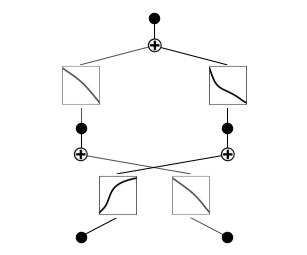

In [33]:
# grids_to_sym = [3, 5, 10, 20]
grids_to_sym = [10]

train_rmse_sym = []
test_rmse_sym = []

model = MultKAN(width=[2,2,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, opt='LBFGS', steps=20,
          lamb=0.01, lamb_entropy=0.1, lamb_coef=0.1, lamb_coefdiff=0.5)
model = model.prune(edge_th=0.03, node_th=0.01)

for i in range(len(grids_to_sym)):
    model = model.refine(grids_to_sym[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse_sym.append(results['train_loss'][-1].item())
    test_rmse_sym.append(results['test_loss'][-1].item())

model.plot()

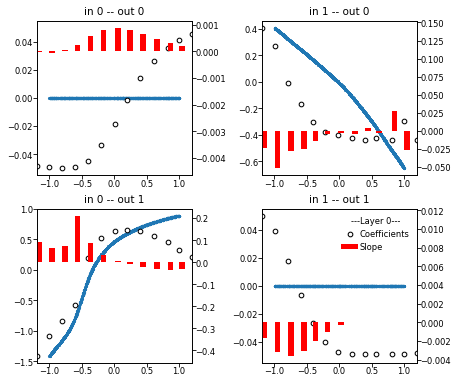

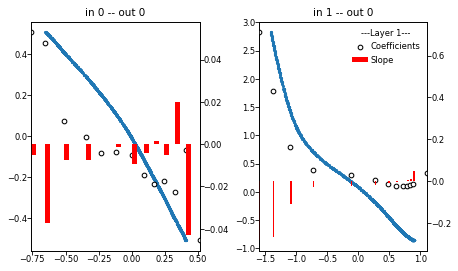

[<Figure size 450x375 with 8 Axes>, <Figure size 450x262.5 with 4 Axes>]

In [34]:
from kan.custom_utils import plot_activation_and_spline_coefficients

plot_activation_and_spline_coefficients(model, x=dataset)

In [35]:
model.auto_symbolic()

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,0,0) with 0
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,0,1) with 0, r2=0.0, c=0
r2 is 0.9997531175613403
fixing (0,1,0) with 1/x^0.5, r2=1.0, c=2
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,1,1) with 0
r2 is 0.9997518062591553
fixing (1,0,0) with exp, r2=1.0, c=2
r2 is 0.9544010162353516
fixing (1,1,0) with x, r2=0.95, c=1


In [36]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0], 4)

1.2081 - 22.3209*exp(-2.9186/sqrt(1 - 0.2912*x_2))

In [37]:
model.fit(dataset)
ex_round(model.symbolic_formula()[0][0], 4)

description:   0%|                                                          | 0/100 [00:00<?, ?it/s]


RuntimeError: No active exception to reraise

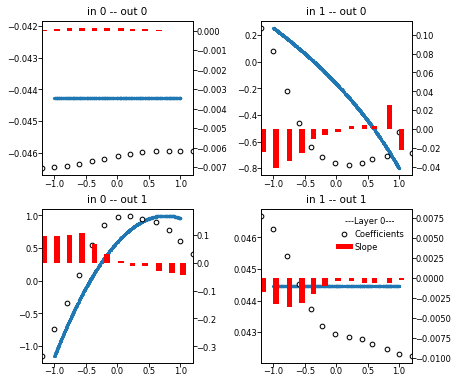

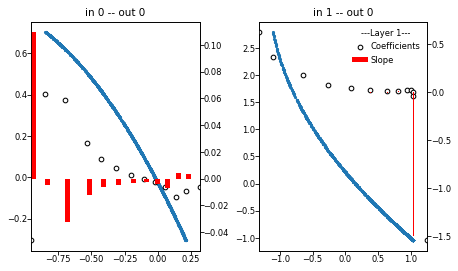

[<Figure size 450x375 with 8 Axes>, <Figure size 450x262.5 with 4 Axes>]

In [24]:
plot_activation_and_spline_coefficients(model, x=dataset)

Text(0, 0.5, 'Attribution score')

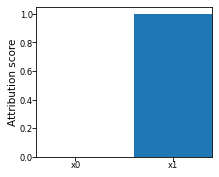

In [17]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

[tensor(251), tensor(241), tensor(256), tensor(252)]


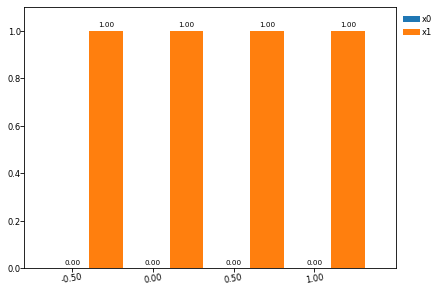

In [18]:
mask_idx = 0
mask_interval = [-1, -0.5, 0., 0.5, 1]
# mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'{ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        model.forward(x_tensor_masked)
        scores_interval.append(model.feature_score.detach().cpu().numpy())
    else:
        scores_interval.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

한 번 spline coefficients의 기울기 방향이 변하는 x1의 영역에 대해서 attribution score를 추적하자.

[tensor(757), tensor(243)]


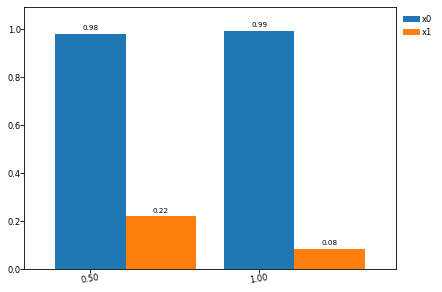

In [9]:
mask_idx = 1
# mask_interval = [-1, -0.5, 0., 0.5, 1]
mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'{ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_norm = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        x_std = torch.std(x_tensor_masked, dim=0).detach().cpu().numpy()
        model.forward(x_tensor_masked)

        score_masked = model.feature_score.detach().cpu().numpy()
        score_norm = score_masked / x_std
        scores_interval.append(score_masked)
        scores_interval_norm.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_norm.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

Attribution score가 input data의 분포에 영향을 받기 때문에 input의 std로 나눠서 비교하기 -- x1의 영역에 대해서는 attribution score의 역전이 일어나지 않음.

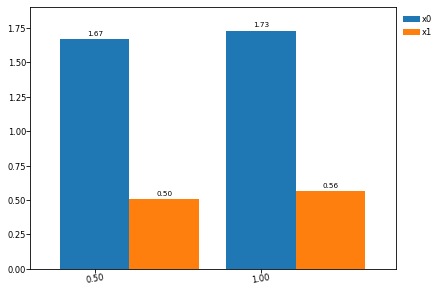

In [10]:
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval_norm])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval_norm], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()